In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster

# 🆕 เพิ่ม ML Libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# กำหนดสไตล์การแสดงผลกราฟ
plt.style.use('dark_background')

1. ดึงข้อมูล BTC (Limit: 300 วัน)...

2. เตรียมข้อมูล LSTM...
--- Training LSTM Model ---


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Training Complete ---

4. ประเมินและทำนายทิศทาง...
   Accuracy (Test Set): 0.7037

5. แสดงกราฟ LSTM Direction Forecast...


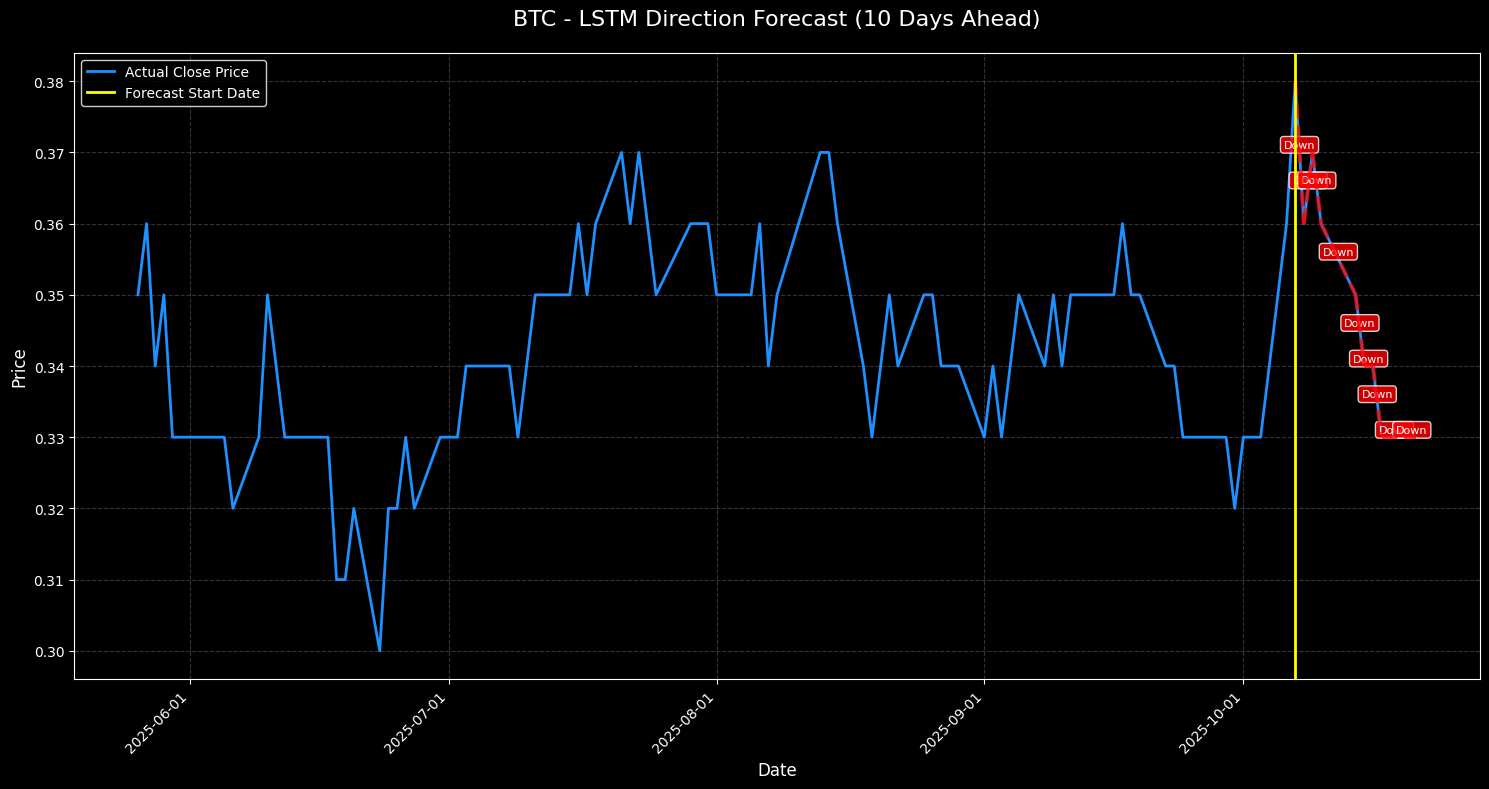

In [12]:
# 1️⃣ ดึงข้อมูลจาก Cassandra (โค้ดเดิม)
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        # NOTE: ตรวจสอบให้แน่ใจว่า Cassandra Server รันอยู่ที่ 127.0.0.1:9042
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    df.rename(columns={'open_price': 'open', 'high_price': 'high', 'low_price': 'low', 'close_price': 'close'}, inplace=True)
    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    # แปลงข้อมูลเป็น float
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

    # 2️⃣ ฟังก์ชันเตรียมข้อมูลสำหรับ LSTM (Scaling & Sequence Creation)
def create_sequences_and_labels(data, seq_length=15):
    """
    เตรียมข้อมูลราคาหุ้นให้อยู่ในรูปแบบที่ LSTM ต้องการ (3D: Samples, Timesteps, Features)
    และสร้าง Target Label สำหรับการคาดการณ์ทิศทาง (1 = ขึ้น, 0 = ลง/คงที่)
    """
    # 1. สร้าง Target Label: 1 ถ้า Close Price ของวันถัดไปสูงกว่าวันนี้, 0 ถ้าต่ำกว่าหรือเท่ากับ
    # การใช้ np.where() จะช่วยให้เราไม่ต้องทำซ้ำข้อมูล
    data['target_direction'] = np.where(data['close'].shift(-1) > data['close'], 1, 0)
    data = data.dropna() # ลบแถวสุดท้ายที่มี NaN จาก shift

    # เลือก Feature ที่จะใช้ในการคาดการณ์ (O, H, L, C, V)
    features = data[['open', 'high', 'low', 'close', 'volume']].values
    labels = data['target_direction'].values

    # 2. Scaling (ปรับขนาดข้อมูล)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(seq_length, len(scaled_features)):
        # X: ลำดับข้อมูลย้อนหลัง (seq_length วัน)
        X.append(scaled_features[i - seq_length:i, :])
        # y: ทิศทางของวันปัจจุบัน (i)
        y.append(labels[i])
        
    return np.array(X), np.array(y), scaler, data.index[seq_length:]


# 3️⃣ ฟังก์ชันสร้างและฝึกโมเดล LSTM
def build_and_train_lstm(X_train, y_train, seq_length, num_features):
    """สร้างโมเดล LSTM สำหรับการจำแนกทิศทาง (Classification)"""
    model = Sequential([
        # LSTM Layer แรก (ตั้ง return_sequences=True เพื่อส่ง output ไปยัง LSTM ถัดไป)
        LSTM(units=50, return_sequences=True, input_shape=(seq_length, num_features)),
        Dropout(0.2),
        
        # LSTM Layer ที่สอง
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        
        # Output Layer: Dense 1 unit พร้อม Sigmoid (สำหรับ Binary Classification: Up/Down)
        Dense(units=1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    print("--- Training LSTM Model ---")
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    print("--- Training Complete ---")
    
    return model

# 4️⃣ ฟังก์ชันคาดการณ์ทิศทาง
def predict_direction(model, X_test):
    """ทำนายทิศทางราคา และแปลงผลลัพธ์จาก 0-1 เป็นทิศทาง (Up/Down)"""
    # ทำนายผลลัพธ์ (ความน่าจะเป็นที่ราคาจะขึ้น)
    predictions = model.predict(X_test, verbose=0)
    
    # แปลงความน่าจะเป็นเป็นทิศทาง (0 หรือ 1)
    predicted_classes = (predictions > 0.5).astype(int)
    
    return predicted_classes.flatten()

    # 5️⃣ Plotting สำหรับ ML Forecast (แก้ไข iloc Error)
def plot_lstm_forecast(dates, actual_prices, predicted_direction, symbol='SYMBOL', forecast_days=10):
    """
    วาดกราฟแสดงราคาจริง และคาดการณ์ทิศทาง 10 วันสุดท้าย
    """
    
    # กรองเอาเฉพาะข้อมูล 100 วันสุดท้าย
    start_idx = max(0, len(dates) - 100)
    
    # 🆕 แก้ไข: แปลง DatetimeIndex เป็น Pandas Series เพื่อใช้ .iloc
    # เนื่องจาก dates คือ Index ของ df ที่ส่งมาจาก Execution
    plot_dates_index = dates[start_idx:]
    plot_dates = pd.Series(plot_dates_index) # <--- สร้าง Series จาก Index
    
    plot_prices = actual_prices[start_idx:]
    plot_direction = predicted_direction[len(predicted_direction) - len(plot_dates):] # ทิศทางที่สอดคล้องกับ plot_dates

    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 1. Plot ราคาจริง
    ax.plot(plot_dates, plot_prices, label='Actual Close Price', color='dodgerblue', linewidth=2)
    
    # 2. Mark จุดเริ่มต้นการคาดการณ์ (10 วันสุดท้าย)
    forecast_start_date = plot_dates.iloc[-forecast_days]
    ax.axvline(forecast_start_date, color='yellow', linestyle='-', linewidth=2, label='Forecast Start Date', zorder=5)

    # 3. Plot ทิศทางที่คาดการณ์ (Forecast)
    for i in range(len(plot_dates) - forecast_days, len(plot_dates) - 1):
        # 🆕 ใช้ .iloc ได้แล้ว เพราะ plot_dates เป็น Series
        current_date = plot_dates.iloc[i] 
        next_date = plot_dates.iloc[i+1]
        
        current_price = plot_prices[i] # ใช้ Index ธรรมดาได้ เพราะ plot_prices เป็น numpy array
        next_price = plot_prices[i+1] # ใช้ Index ธรรมดาได้ เพราะ plot_prices เป็น numpy array

        direction = plot_direction[i]
        
        # กำหนดสีตามทิศทางที่คาดการณ์
        line_color = 'red' if direction == 0 else 'lime' # 0=ลง/แดง, 1=ขึ้น/เขียว

        # ลากเส้นคาดการณ์ 
        ax.plot([current_date, next_date], [current_price, next_price], 
                color=line_color, linestyle='--', linewidth=3, alpha=0.7, zorder=4)
                
        # Annotate ทิศทาง
        # การบวก/ลบ DatetimeIndex ทำได้เมื่อใช้ pandas.Timedelta
        mid_date = current_date + (next_date - current_date) / 2 
        mid_price = (current_price + next_price) / 2
        ax.annotate('Up' if direction == 1 else 'Down', 
                    (mid_date, mid_price * 1.001), 
                    color='white', fontsize=8, ha='center', va='bottom', 
                    bbox=dict(facecolor=line_color, alpha=0.8, boxstyle="round,pad=0.3"))


    # --- ปรับแต่งกราฟ ---
    ax.set_title(f"{symbol} - LSTM Direction Forecast ({forecast_days} Days Ahead)", color='white', fontsize=16, pad=20)
    ax.set_xlabel("Date", color='white', fontsize=12)
    ax.set_ylabel("Price", color='white', fontsize=12)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    
    # จัดการ Legend ให้ไม่ซ้ำกัน
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), facecolor='black', edgecolor='white', loc='upper left')

    plt.tight_layout()
    plt.show()

    # 6️⃣ ตัวอย่างการใช้งาน (Execution - ML)
try:
    # --- Config ---
    symbol = "BTC" # หุ้นที่ใช้ในตัวอย่างการคาดการณ์ (ใช้ PTT ก็ได้)
    DATA_LIMIT = 300  
    SEQUENCE_LENGTH = 30 # ใช้ข้อมูลย้อนหลัง 30 วันในการคาดการณ์ 1 วันถัดไป
    TRAIN_SPLIT = 0.8  # แบ่งข้อมูล 80% เป็น Training, 20% เป็น Testing
    
    print(f"1. ดึงข้อมูล {symbol} (Limit: {DATA_LIMIT} วัน)...")
    df = get_candlestick_data(symbol, limit=DATA_LIMIT)
    
    # 2. เตรียมข้อมูลสำหรับ LSTM
    print("\n2. เตรียมข้อมูล LSTM...")
    X, y, scaler, dates = create_sequences_and_labels(df.copy(), seq_length=SEQUENCE_LENGTH)
    
    # แบ่งข้อมูล Train/Test
    train_size = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # 3. สร้างและฝึกโมเดล LSTM
    num_features = X.shape[2]
    model = build_and_train_lstm(X_train, y_train, SEQUENCE_LENGTH, num_features)
    
    # 4. ทดสอบและคาดการณ์
    print("\n4. ประเมินและทำนายทิศทาง...")
    
    # ประเมินบน Test Set
    y_pred_test = predict_direction(model, X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"   Accuracy (Test Set): {accuracy:.4f}")
    
    # ทำนายทิศทางสำหรับชุดข้อมูลทั้งหมด (เพื่อใช้ในการ Plot)
    y_pred_all = predict_direction(model, X)
    
    # 5. แสดงผลกราฟ
    print("\n5. แสดงกราฟ LSTM Direction Forecast...")
    # ใช้ราคาจริงที่สอดคล้องกับข้อมูลที่ใช้ในการทำนาย (เริ่มจาก index SEQUENCE_LENGTH)
    actual_prices = df['close'][dates].values 
    plot_lstm_forecast(dates, actual_prices, y_pred_all, symbol=symbol, forecast_days=10)
    
except ConnectionRefusedError as e:
    print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
    print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
except ValueError as e:
    print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
except Exception as e:
    print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")
    print(f"Detail: {e}")